<a href="https://colab.research.google.com/github/Gheras13/Homework/blob/main/Homewrok_1_5r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MACHINE LEARNING HOMEWORK 1

#DIRECT KINEMATICS OF ROBOT MANIPLUATOR

In [14]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [15]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Generate Data

In [16]:


# Percorso del file CSV
file_path = '/content/drive/My Drive/File_csv/Copia di r5_20_100k.csv'
# Carica il dataset
dataset = pd.read_csv(file_path, sep=';', header=0)

# Rimuovi eventuali spazi dai nomi delle colonne
dataset.columns = dataset.columns.str.strip()
#prendo i primi 1000 samples
df = dataset.iloc[:30000]
# Stampa i nomi delle colonne disponibili
print("Colonne disponibili nel dataset:", df.columns.tolist())

# Estrai le feature (j0, j1) e i target (ee_x, ee_y)
X = df[['j0', 'j1','j2','j3','j4']].values  # Angoli articolari
Y = df[['ee_x', 'ee_y']].values  # Posizioni finali (end-effector)

# Verifica i dati caricati
print("Esempio di X (features):", X[:5])  # Prime 5 righe delle feature
print("Esempio di Y (target):", Y[:5])  # Prime 5 righe del target


Colonne disponibili nel dataset: ['j0', 'j1', 'j2', 'j3', 'j4', 'cos(j0)', 'cos(j1)', 'cos(j2)', 'cos(j3)', 'cos(j4)', 'sin(j0)', 'sin(j1)', 'sin(j2)', 'sin(j3)', 'sin(j4)', 'ee_x', 'ee_y', 'ee_z', 'ee_qw', 'ee_qx', 'ee_qy', 'ee_qz']
Esempio di X (features): [[ 0.     0.     0.     0.     0.   ]
 [-0.017 -0.003 -0.03   0.002 -0.007]
 [-0.086 -0.04  -0.05   0.021 -0.025]
 [-0.176 -0.125 -0.047  0.022 -0.083]
 [-0.228 -0.202 -0.098 -0.025 -0.207]]
Esempio di Y (target): [[ 0.     0.   ]
 [-0.011  0.001]
 [-0.03   0.006]
 [-0.065  0.022]
 [-0.12   0.053]]


In [17]:
# Dividi i dati in training e testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


# Test del modello

Rete neurale FeedForward con tensorflow

Definisce una rete neurale feedforward in cui i layer sono collegati uno dopo l'altro (architettura sequenziale).
Ogni layer prende in input l'output del layer precedente.

Definizione di una rete neurale feedforward per la cinematica diretta.
 Struttura:
 - Input: 2 caratteristiche (angoli articolari).
 - 3 layer nascosti con attivazione ReLU.
 - Output: 2 caratteristiche (posizione terminale x, y).


In [18]:
def build_model(hidden_neurons, learning_rate, dropout_rate=None, l2_lambda=None):
    """
    Crea un modello configurabile con dropout e regolarizzazione L2.

    Args:
        hidden_neurons (int): Numero di neuroni negli strati nascosti.
        learning_rate (float): Tasso di apprendimento.
        dropout_rate (float, optional): Percentuale di dropout (None per nessun dropout).
        l2_lambda (float, optional): Coefficiente di regolarizzazione L2 (None per nessuna regolarizzazione).

    Returns:
        tf.keras.Sequential: Modello compilato.
    """
    layers = [
        tf.keras.layers.Dense(
            hidden_neurons, activation='relu', input_shape=(5,),
            kernel_regularizer=tf.keras.regularizers.l2(l2_lambda) if l2_lambda else None
        )
    ]

    if dropout_rate:
        layers.append(tf.keras.layers.Dropout(dropout_rate))  # Aggiungi Dropout

    layers.extend([
        tf.keras.layers.Dense(
            hidden_neurons, activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(l2_lambda) if l2_lambda else None
        ),
        tf.keras.layers.Dense(2)  # Output: posizione (x, y)
    ])

    model = tf.keras.Sequential(layers)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae']
    )
    return model


 Configurazione del modello per l'addestramento:
 - Ottimizzatore: Adam (learning_rate=0.01).
 - Funzione di perdita: Mean Squared Error (MSE).
 - Metriche: Mean Absolute Error (MAE).


# Valutazione finale del modello sul set di test.
# Metriche:
# - `loss`: Errore quadratico medio (MSE), risulterà essere la nostra LOSS FUNCTION.
# - `mae`: Errore assoluto medio.
# Come SOLVER è stato scelto ADAM


#GRID SEARCH

In [19]:
from itertools import product

# Parametri per il tuning del modello base
hidden_layers = [64, 128]
learning_rates = [0.01, 0.001]

results = []

print("Tuning sul modello base...")
for hl, lr in product(hidden_layers, learning_rates):
    print(f"Testing Baseline Model with {hl} hidden neurons and {lr} learning rate")

    # Costruisci il modello base
    model_baseline = build_model(hidden_neurons=hl, learning_rate=lr)
    history = model_baseline.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=32, verbose=0)
    loss, mae = model_baseline.evaluate(X_test, Y_test, verbose=0)
    results.append((hl, lr, loss, mae))

# Riporta i risultati migliori per il modello base
sorted_results = sorted(results, key=lambda x: x[2])  # Ordina per perdita
best_config = sorted_results[0]
print(f"Miglior configurazione trovata per il modello base: Neuroni Nascosti={best_config[0]}, Learning Rate={best_config[1]}")


Tuning sul modello base...
Testing Baseline Model with 64 hidden neurons and 0.01 learning rate


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Testing Baseline Model with 64 hidden neurons and 0.001 learning rate
Testing Baseline Model with 128 hidden neurons and 0.01 learning rate
Testing Baseline Model with 128 hidden neurons and 0.001 learning rate
Miglior configurazione trovata per il modello base: Neuroni Nascosti=128, Learning Rate=0.001


In [20]:
# Parametri ottimali trovati dal tuning
optimal_hidden_neurons = best_config[0]
optimal_learning_rate = best_config[1]

# Configurazioni per Dropout e Weight Decay
dropout_rate = 0.2
l2_lambda = 0.001

# Lista per i risultati finali
final_results = []

# 1. Modello Base
print("\nAddestramento Modello Base...")
model_baseline = build_model(hidden_neurons=optimal_hidden_neurons, learning_rate=optimal_learning_rate)
history_baseline = model_baseline.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=32, verbose=0)
loss, mae = model_baseline.evaluate(X_test, Y_test, verbose=0)
final_results.append(('Baseline', loss, mae))

# 2. Modello con Dropout
print("\nAddestramento Modello con Dropout...")
model_dropout = build_model(hidden_neurons=optimal_hidden_neurons, learning_rate=optimal_learning_rate, dropout_rate=dropout_rate)
history_dropout = model_dropout.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=32, verbose=0)
loss, mae = model_dropout.evaluate(X_test, Y_test, verbose=0)
final_results.append(('Dropout', loss, mae))

# 3. Modello con Weight Decay
print("\nAddestramento Modello con Weight Decay...")
model_l2 = build_model(hidden_neurons=optimal_hidden_neurons, learning_rate=optimal_learning_rate, l2_lambda=l2_lambda)
history_l2 = model_l2.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=32, verbose=0)
loss, mae = model_l2.evaluate(X_test, Y_test, verbose=0)
final_results.append(('Weight Decay', loss, mae))



Addestramento Modello Base...

Addestramento Modello con Dropout...

Addestramento Modello con Weight Decay...



Confronto Finale tra i Modelli:
Modello: Baseline, Loss: 0.0000, MAE: 0.0053
Modello: Dropout, Loss: 0.0003, MAE: 0.0125
Modello: Weight Decay, Loss: 0.0015, MAE: 0.0164


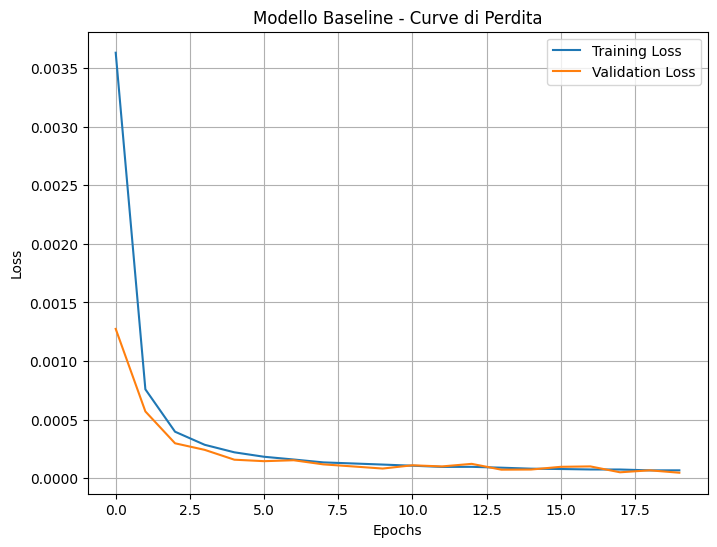

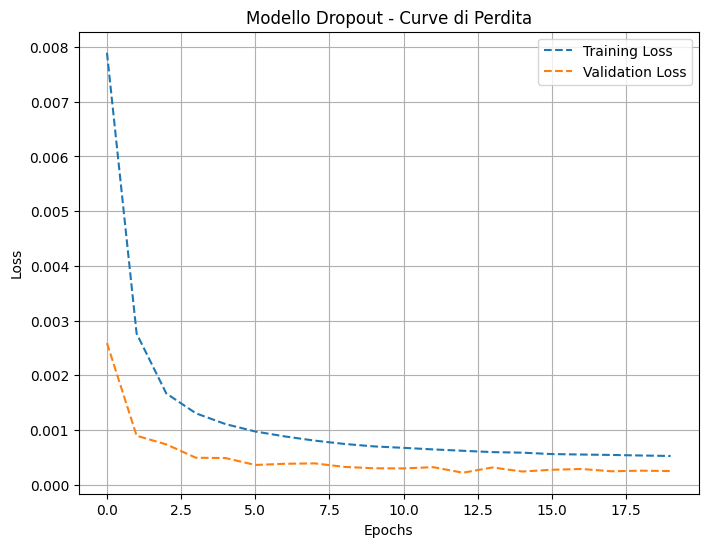

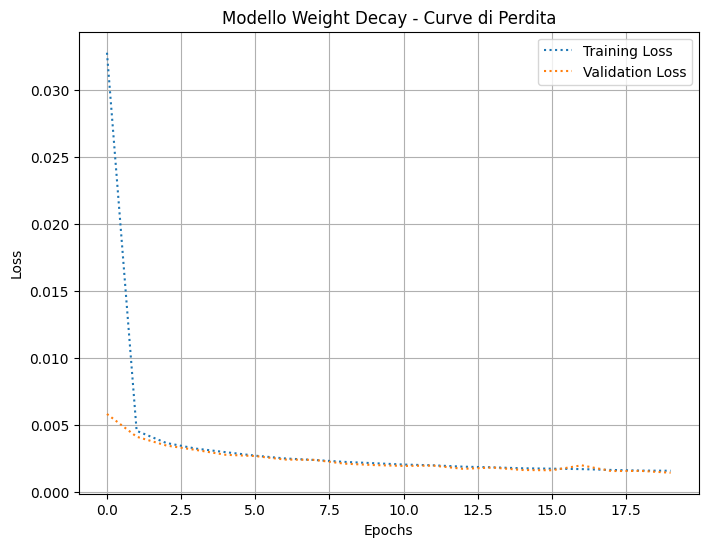

In [21]:
# Visualizza i risultati finali
print("\nConfronto Finale tra i Modelli:")
for res in final_results:
    print(f"Modello: {res[0]}, Loss: {res[1]:.4f}, MAE: {res[2]:.4f}")

# Grafico per il Modello Base
plt.figure(figsize=(8, 6))
plt.plot(history_baseline.history['loss'], label='Training Loss')
plt.plot(history_baseline.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Modello Baseline - Curve di Perdita')
plt.legend()
plt.grid(True)
plt.show()

# Grafico per il Modello Dropout
plt.figure(figsize=(8, 6))
plt.plot(history_dropout.history['loss'], label='Training Loss', linestyle='dashed')
plt.plot(history_dropout.history['val_loss'], label='Validation Loss', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Modello Dropout - Curve di Perdita')
plt.legend()
plt.grid(True)
plt.show()

# Grafico per il Modello Weight Decay
plt.figure(figsize=(8, 6))
plt.plot(history_l2.history['loss'], label='Training Loss', linestyle='dotted')
plt.plot(history_l2.history['val_loss'], label='Validation Loss', linestyle='dotted')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Modello Weight Decay - Curve di Perdita')
plt.legend()
plt.grid(True)
plt.show()


#Definizione dei jacobiani

In [22]:
@tf.function
def FK_Jacobian(model, x):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        y = FK(model, x)  # Forward pass
    return tape.jacobian(y, x)

def FK(model, theta):
    # Reshape to batch size 1
    t = tf.reshape(theta, shape=(1, 5))
    out = model(t)
    # Reshape to 1d vector
    out = tf.reshape(out, shape=(2,))
    return out

import numpy as np

def analytical_J_5R(theta, L=[0.1, 0.1, 0.1, 0.1, 0.1]):
    """
    Calcola la Jacobiana analitica per un robot 5R.
    """
    theta = np.cumsum(theta)  # Somma cumulativa degli angoli
    J = np.zeros((2, 5))

    # Calcolo delle derivate
    for i in range(5):
        J[0, i] = -sum(L[j] * np.sin(theta[j]) for j in range(i, 5))  # Derivata parziale di x
        J[1, i] = sum(L[j] * np.cos(theta[j]) for j in range(i, 5))   # Derivata parziale di y

    return J


In [23]:
# Definizione dei modelli già addestrati
models = {
    "Baseline": model_baseline,
    "Dropout": model_dropout,
    "Weight Decay": model_l2
}

# Parametri del robot
L =[ 0.1, 0.1, 0.1, 0.1, 0.1] # Lunghezze dei link (modifica se necessario)

# Campione di test
theta_sample = X_test[0]  # Primo esempio di test

# Confronto per ciascun modello
for model_name, model in models.items():
    print(f"\nConfronto per il modello: {model_name}")

    # Calcolo della Jacobiana appresa
    jacobian_learned = FK_Jacobian(model, tf.convert_to_tensor([theta_sample], dtype=tf.float32))

    # Calcolo della Jacobiana analitica
    jacobian_analytical = analytical_J_5R(theta_sample, L)

    # Flatten delle matrici
    jacobian_learned_flat = jacobian_learned.numpy().flatten()
    jacobian_analytical_flat = jacobian_analytical.flatten()

    # Calcolo del MSE
    mse = np.mean((jacobian_learned_flat - jacobian_analytical_flat) ** 2)


    # Visualizza le Jacobiane
    print("\nJacobiana appresa:\n", jacobian_learned.numpy())
    print("\nJacobiana analitica:\n", jacobian_analytical)
    print("\nMean Squared Error (MSE): ",mse)


Confronto per il modello: Baseline

Jacobiana appresa:
 [[[ 0.01397477 -0.15576622 -0.18406162 -0.12694359 -0.0429985 ]]

 [[-0.19268847  0.11260122  0.12125707  0.08348632 -0.02512658]]]

Jacobiana analitica:
 [[ 0.04094802 -0.02743506 -0.10816684 -0.12188273 -0.02565078]
 [-0.20894888 -0.28191294 -0.22290125 -0.12384634 -0.09665422]]

Mean Squared Error (MSE):  0.03457368279563576

Confronto per il modello: Dropout

Jacobiana appresa:
 [[[ 0.01164352 -0.16042233 -0.20297204 -0.14439505 -0.04665625]]

 [[-0.03214452  0.09668858  0.14459535  0.09302889  0.00942386]]]

Jacobiana analitica:
 [[ 0.04094802 -0.02743506 -0.10816684 -0.12188273 -0.02565078]
 [-0.20894888 -0.28191294 -0.22290125 -0.12384634 -0.09665422]]

Mean Squared Error (MSE):  0.039642050039452995

Confronto per il modello: Weight Decay

Jacobiana appresa:
 [[[-0.02042477 -0.11919197 -0.14517966 -0.11386335 -0.01446998]]

 [[-0.13831545  0.0968425   0.11388077  0.08912029 -0.05003122]]]

Jacobiana analitica:
 [[ 0.04094